#Machine Learning Final Project – Predicting the price of second hand cars

### Hil Alcee, Ricollis Jones, Radhika Mardikar, Tres Pimentel

### Introduction
This project aims to predict the price of second hand cars sold on markets like Craigslist. The dataset comes from kaggle and is sourced from Craigslist. The data from Craigslist is scraped every few months and added onto the kaggle website. There are around 450k examples and the dataset contains information like price, model, condition, manufacturer, latitude/longitude, area, region and more. In this analysis, we narrow the scope of the problem by doing EDA, preprocessing, and then creating the appropriate models.

Data: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

In [ ]:
# General libraries.
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

### EDA/Pre-processing
We first checked data types of the different columns, changed the year column type to string, and did outlier detection. 

In [ ]:
df = pd.read_csv('vehicles.csv',engine='python', error_bad_lines=False)
# show columns
print(df.columns)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 128120: unexpected end of data


Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')


In [ ]:
# Sanity checking data types
df.dtypes

id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
county          float64
state            object
lat             float64
long            float64
posting_date     object
dtype: object

In [ ]:
df.shape

(128118, 26)

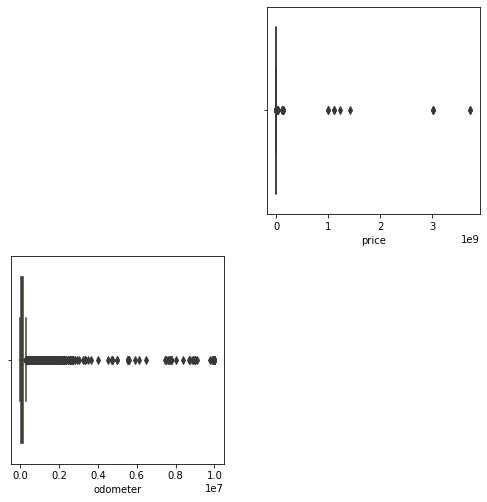

In [ ]:
#outlier detection in numerical
fig=plt.figure(figsize=(13,13))
axes=330

#put numerical
for num in df[['price','odometer']]:
    axes += 2
    fig.add_subplot(axes)
    #set title of num
    sns.boxplot(data = df[['price','odometer']], x=num, color="y") 
    
plt.show()

We filtered the outliers for price,odometer, and year as they skewed our data greatly. In response, we created a threshold of $50,000 on the price of a car as most used cars wouldn’t be reasonably sold at new car prices.The odometer had a major outlier of 1,000,000 miles for one listing so we needed to remove cars that didn't appear to be reasonable milage for a sellable used car, so we set a 180,000 mile threshold to group our data set more tightly. Additionally, we wanted to set a minimum threshold year for the listed cars as presumably buyers would not want a car that is 80 years old i.e. a car listed in the data set for the year 1913. To remedy this, we set the threshold to 1960 and newer.

In [ ]:
df = df[df['price']<50000]
df = df[df['odometer']<180000]
df = df[df['year']>1960]
df = df[df['price']> 1]
df

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
27,7316814884,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,...,NaN,pickup,white,https://images.craigslist.org/00R0R_lwWjXSEWNa...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000,2021-05-04T12:31:18-0500
28,7316814758,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,...,NaN,pickup,blue,https://images.craigslist.org/00R0R_lwWjXSEWNa...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000,2021-05-04T12:31:08-0500
29,7316814989,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/01212_jjirIWa0y0...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000,2021-05-04T12:31:25-0500
30,7316743432,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/00x0x_1y9kIOzGCF...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000,2021-05-04T10:41:31-0500
31,7316356412,https://auburn.craigslist.org/cto/d/auburn-uni...,auburn,https://auburn.craigslist.org,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,...,full-size,truck,black,https://images.craigslist.org/00404_l4loxHvdQe...,2013 F-150 XLT V6 4 Door. Good condition. Leve...,NaN,al,32.592000,-85.518900,2021-05-03T14:02:03-0500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128112,7316277946,https://honolulu.craigslist.org/big/ctd/d/kail...,hawaii,https://honolulu.craigslist.org,49000,2018.0,bmw,x3 m40i,NaN,6 cylinders,...,NaN,SUV,silver,https://images.craigslist.org/00M0M_eKy3pAHZKt...,"2018 BMW X3 M40i -- $49,000 ☎ Call: (808...",NaN,hi,19.646976,-156.001730,2021-05-03T07:01:18-1000
128113,7316277779,https://honolulu.craigslist.org/big/ctd/d/kail...,hawaii,https://honolulu.craigslist.org,15595,2011.0,lexus,is 250,NaN,6 cylinders,...,NaN,sedan,grey,https://images.craigslist.org/00H0H_7TInjGyBrF...,"2011 Lexus IS 250 -- $15,595 ☎ Call: (80...",NaN,hi,19.646976,-156.001730,2021-05-03T07:01:07-1000
128115,7316277591,https://honolulu.craigslist.org/oah/ctd/d/kail...,hawaii,https://honolulu.craigslist.org,39000,2018.0,bmw,530i,NaN,4 cylinders,...,NaN,sedan,white,https://images.craigslist.org/00K0K_bwynWjYM3X...,"2018 BMW 530i -- $39,000 ☎ Call: (808) 2...",NaN,hi,19.646976,-156.001730,2021-05-03T07:00:54-1000
128116,7316277000,https://honolulu.craigslist.org/oah/ctd/d/hono...,hawaii,https://honolulu.craigslist.org,256,2015.0,toyota,rav4 fwd 4dr le,NaN,4 cylinders,...,NaN,SUV,NaN,https://images.craigslist.org/00Y0Y_ccgcfkkV4F...,Acura of Honolulu STOCK #: X0899 ...,NaN,hi,21.336555,-157.912790,2021-05-03T07:00:08-1000


We narrowed the scope of the problem to include only the top few most important manufacturers.

In [ ]:
df['manufacturer'].value_counts()

ford               14236
chevrolet          10960
toyota              8785
honda               5413
nissan              5280
bmw                 4493
jeep                3938
mercedes-benz       3554
ram                 3259
dodge               3048
hyundai             3001
gmc                 2806
volkswagen          2748
lexus               2637
kia                 2348
subaru              2292
audi                2039
cadillac            1735
acura               1691
mazda               1561
chrysler            1363
infiniti            1355
buick                987
lincoln              973
volvo                959
mini                 817
mitsubishi           710
rover                613
jaguar               536
porsche              390
pontiac              331
fiat                 327
alfa-romeo           272
tesla                256
mercury              256
saturn               232
harley-davidson       35
datsun                23
aston-martin           4
land rover             3


In [ ]:
print(len(df['manufacturer'].unique()))

41


In [ ]:
print(df['manufacturer'].value_counts()[0:17].sum())
print(df['manufacturer'].value_counts().sum())

80837
96266


In [ ]:
manulist = ['ford', 'chevrolet', 'toyota', 'honda', 'nissan', 'jeep', 'gmc','bmw', 'dodge', 'mercedes', 'hyundai', 
            'subaru', 'volkswagen', 'kia', 'lexus', 'audi','chrysler']
df = df[df['manufacturer'].isin(manulist) ]

df

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
27,7316814884,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,...,NaN,pickup,white,https://images.craigslist.org/00R0R_lwWjXSEWNa...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000,2021-05-04T12:31:18-0500
28,7316814758,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,...,NaN,pickup,blue,https://images.craigslist.org/00R0R_lwWjXSEWNa...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000,2021-05-04T12:31:08-0500
29,7316814989,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/01212_jjirIWa0y0...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000,2021-05-04T12:31:25-0500
30,7316743432,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/00x0x_1y9kIOzGCF...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000,2021-05-04T10:41:31-0500
31,7316356412,https://auburn.craigslist.org/cto/d/auburn-uni...,auburn,https://auburn.craigslist.org,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,...,full-size,truck,black,https://images.craigslist.org/00404_l4loxHvdQe...,2013 F-150 XLT V6 4 Door. Good condition. Leve...,NaN,al,32.592000,-85.518900,2021-05-03T14:02:03-0500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426871,7301591639,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,17990,2018.0,kia,sportage lx sport utility 4d,good,NaN,...,NaN,SUV,NaN,https://images.craigslist.org/00U0U_4VvCQuqnfb...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:30:20-0600
426874,7301591199,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,33590,2018.0,lexus,gs 350 sedan 4d,good,6 cylinders,...,NaN,sedan,white,https://images.craigslist.org/00I0I_hJHfjCUppa...,Carvana is the safer way to buy a car During t...,NaN,wy,33.779214,-84.411811,2021-04-04T03:21:34-0600
426875,7301591192,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,...,NaN,sedan,NaN,https://images.craigslist.org/00o0o_iiraFnHg8q...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:31-0600
426878,7301591140,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,...,NaN,sedan,silver,https://images.craigslist.org/00z0z_bKnIVGLkDT...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:11-0600


We dropped unnecessary columns and NANs.

In [ ]:
#Dropping unnecessary columns for our analysis

drop_cols =['url','image_url','region_url', 'size', 'VIN','county','id','description','lat','long','model']
df.drop(columns=drop_cols , axis=1, inplace=True)

df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df

df.shape
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
31,auburn,15000,2013.0,ford,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,2021-05-03T14:02:03-0500
32,auburn,27990,2012.0,gmc,good,8 cylinders,gas,68696.0,clean,other,4wd,pickup,black,al,2021-05-03T13:41:25-0500
33,auburn,34590,2016.0,chevrolet,good,6 cylinders,gas,29499.0,clean,other,4wd,pickup,silver,al,2021-05-03T12:41:33-0500
34,auburn,35000,2019.0,toyota,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey,al,2021-05-03T12:12:59-0500
35,auburn,29990,2016.0,chevrolet,good,6 cylinders,gas,17302.0,clean,other,4wd,pickup,red,al,2021-05-03T11:31:14-0500


In [ ]:
category = ['manufacturer','cylinders','fuel','title_status','transmission','drive','type','paint_color','condition','year','posting_date'
           ,'state','region']
numerical = df.drop(category, axis=1)
categorical = df[category]
numerical.head()

,price,odometer
31,15000,128000.0
32,27990,68696.0
33,34590,29499.0
34,35000,43000.0
35,29990,17302.0


In [ ]:
df['price'].quantile(0.25)

7000.0

-19385.0
50975.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.show>

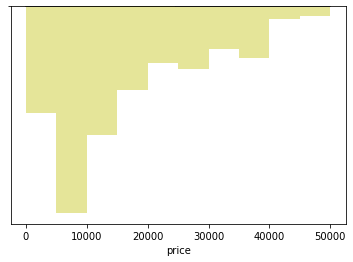

In [ ]:
df['price'].quantile(0.75)

Q1= df['price'].quantile(0.25)

Q3 = df['price'].quantile(0.75)

IQR = Q3-Q1

IQR

lower_l = Q1 -1.5 * IQR

upper_l = Q3+ 1.5 * IQR

print(lower_l)
print(upper_l)

out_l= (df['price'] < lower_l)

out_u= (df['price'] > upper_l)

len (df['price']) - (len (df['price'] [out_l]) + len (df['price'][out_u]))

df['price'][(out_l| out_u)]

df['price'][~(out_l | out_u)]

df = df[~(out_l | out_u)]
df

sns.boxplot(x= df['price'], color='y')
plt.show


sns.distplot(df['price'], bins=10 ,kde = False, color='y')
plt.show

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


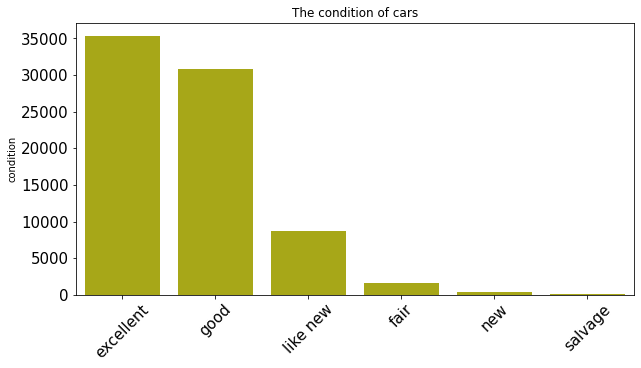

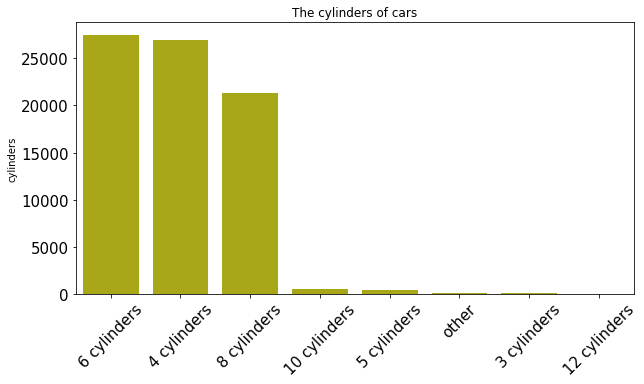

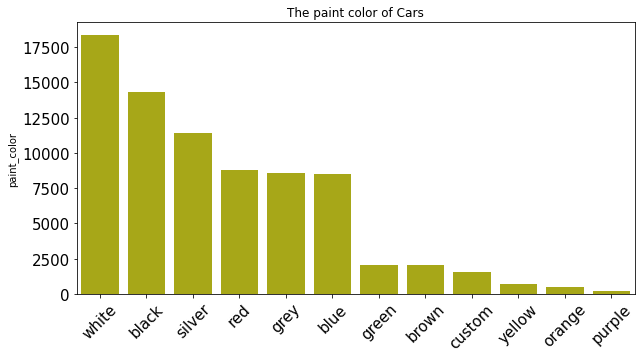

In [ ]:
#1 For Category
con=df['condition'].value_counts().head(30)
plt.figure(figsize=(10,5))
sns.barplot(con.index,con, color='y')
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15);
plt.title('The condition of cars');

#2
cl=df['cylinders'].value_counts().head(30)
plt.figure(figsize=(10,5))
sns.barplot(cl.index,cl ,color='y')
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15);
plt.title('The cylinders of cars');

#3
paint=df['paint_color'].value_counts().head(30)
plt.figure(figsize=(10,5))
sns.barplot(paint.index,paint, color='y')
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15);
plt.title('The paint color of Cars');

In [ ]:
# statistic information 
df.describe()

,price,year,odometer
count,76970.000000,76970.000000,76970.000000
mean,16424.527621,2010.560036,91977.214863
std,11635.833709,8.289923,48828.468499
min,3.000000,1961.000000,0.000000
25%,7000.000000,2008.000000,51525.000000
50%,12900.000000,2012.000000,96500.000000
75%,24590.000000,2016.000000,131730.000000
max,49999.000000,2021.000000,179998.000000


We ensure that the earlier pre-processing dropped the outliers in price.

In [ ]:
print("The maximum and minimum car prices")
print(df['price'].max())
print(df['price'].min())

The maximum and minimum car prices
49999
3


Some of the features in the dataset are categorical while others are numerical. We split the columns accordingly based on their data type and used the get_dummies method to convert the categorical data into usable data types.

In [ ]:
# fill categorical with mode
for cat in categorical:
    mode = categorical[cat].mode().values[0]
    categorical[cat]=df[cat].fillna(mode)

In [ ]:
categorical.head()

,manufacturer,cylinders,fuel,title_status,transmission,drive,type,paint_color,condition,year,posting_date,state,region
31,ford,6 cylinders,gas,clean,automatic,rwd,truck,black,excellent,2013.0,2021-05-03T14:02:03-0500,al,auburn
32,gmc,8 cylinders,gas,clean,other,4wd,pickup,black,good,2012.0,2021-05-03T13:41:25-0500,al,auburn
33,chevrolet,6 cylinders,gas,clean,other,4wd,pickup,silver,good,2016.0,2021-05-03T12:41:33-0500,al,auburn
34,toyota,6 cylinders,gas,clean,automatic,4wd,truck,grey,excellent,2019.0,2021-05-03T12:12:59-0500,al,auburn
35,chevrolet,6 cylinders,gas,clean,other,4wd,pickup,red,good,2016.0,2021-05-03T11:31:14-0500,al,auburn


In [ ]:
numerical.head()

,price,odometer
31,15000,128000.0
32,27990,68696.0
33,34590,29499.0
34,35000,43000.0
35,29990,17302.0


In [ ]:
#concat table categorical and numerical to create new table without missing values
df2 = pd.concat([categorical,numerical],axis=1)
df2.head()

,manufacturer,cylinders,fuel,title_status,transmission,drive,type,paint_color,condition,year,posting_date,state,region,price,odometer
31,ford,6 cylinders,gas,clean,automatic,rwd,truck,black,excellent,2013.0,2021-05-03T14:02:03-0500,al,auburn,15000,128000.0
32,gmc,8 cylinders,gas,clean,other,4wd,pickup,black,good,2012.0,2021-05-03T13:41:25-0500,al,auburn,27990,68696.0
33,chevrolet,6 cylinders,gas,clean,other,4wd,pickup,silver,good,2016.0,2021-05-03T12:41:33-0500,al,auburn,34590,29499.0
34,toyota,6 cylinders,gas,clean,automatic,4wd,truck,grey,excellent,2019.0,2021-05-03T12:12:59-0500,al,auburn,35000,43000.0
35,chevrolet,6 cylinders,gas,clean,other,4wd,pickup,red,good,2016.0,2021-05-03T11:31:14-0500,al,auburn,29990,17302.0


We also show a price histogram to see how price is distributed. We will create another column called “Price Bin” that sorts rows based on the bins their price falls into

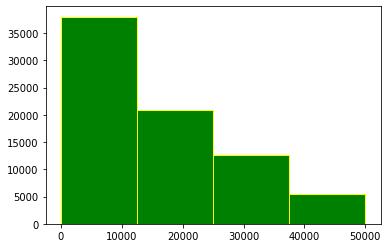

In [ ]:
n, bins, patches = plt.hist(df['price'], bins=4, edgecolor="yellow", color="green")
plt.show()
df_bins = df
df_bins['price_bin'] = df_bins.apply(lambda x: [float(i) for i in bins if x['price']< i] , axis=1)
df_bins['price_bin2'] = df_bins.apply(lambda x: float(x['price_bin'][0]) if x['price_bin'] else 0, axis = 1)

In [ ]:
for_dummies = ['region', 'year', 'manufacturer',  'condition',
       'cylinders', 'fuel', 'title_status', 'transmission',
       'drive', 'type', 'paint_color', 'state']
for_continuous = ['price','odometer']

for_binprice = ['price_bin2']

In [ ]:
dummy_cat = pd.get_dummies(df[for_dummies],drop_first=True,sparse =False)
df_final = pd.concat([dummy_cat,df[for_continuous]],axis=1).sample(70000)

In [ ]:
dummy_cat_bins = pd.get_dummies(df_bins[for_dummies],drop_first=True,sparse =False)
df_final_bins = pd.concat([dummy_cat_bins,df_bins[for_binprice]],axis=1).sample(70000)

### Model Building
We will build two types of models. The first one is a regressor model that will predict the price of the car based on the input features. The second model is a classifier model that will predict the price bin the car falls in. These models are useful for people who’d like to know exactly how much their car is worth and for those who’d like a ballpark based on generic features of their car.

This is the first model (Regressor)


For the first regression model, since we have many categorical variables which were binarized with the dummy variable feature, a Random Forest regressor model will be the most optimal type of model for us. The Random Forest is expected to perform well because of its random iteration of decision trees and its average of the outcome of all the final results.  


We will split the data into training, dev, and test sets split into 80%,10%, and 10% respectively.

In [ ]:
X,Y = df_final.loc[:, df_final.columns != 'price'],df_final.loc[:, df_final.columns == 'price']

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size=0.20, random_state=42)
dev_data,test_data, dev_labels,test_labels = train_test_split(test_data, test_labels, test_size=0.50, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# define used regressor
forest=RandomForestRegressor(n_estimators=20,
                             max_depth=10,
                             criterion='mse',
                            )

# train model
forest.fit(train_data,train_labels)
forest.score(dev_data,dev_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


0.8603523479969698

In [ ]:
# let's experiment with values a little

high_score = 0
high_n = 0
high_depth = 0

for n_estimator in range(10,20):
    for depth in range(7,12):
        forest=RandomForestRegressor(n_estimators=n_estimator,
                                 max_depth=depth,
                                 criterion='mse',
                                )

    # train model
        forest.fit(train_data,train_labels)
        temp_score = forest.score(dev_data,dev_labels)

        if temp_score > high_score:
            high_score = temp_score
            high_n = n_estimator
            high_depth = depth

print('n = ',high_n, 'depth = ', high_depth, 'score = ', high_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib

n =  17 depth =  11 score =  0.8715479733057864


The R2 coefficient reflects how well the line fits and how well the dev set fits. The coefficient is not very high but does a decent job at predicting the price of second hard cars.

Now that performance is more optimized, it would be interesting to understand how important each feature is to the overall decision.

In [ ]:
# now performance is a little higher, let's get the importance of each feature

forest=RandomForestRegressor(n_estimators=high_n,
                                 max_depth=high_depth,
                                 criterion='mse',
                                )

forest.fit(train_data,train_labels)

scores = []

for col, importance in zip(X.columns, forest.feature_importances_):
    scores.append((col, importance))
scores.sort(key = lambda x: x[1], reverse = True)
print(scores[:5])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


[('year', 0.36681284352479104), ('odometer', 0.2037027161562447), ('cylinders_4 cylinders', 0.1595255889409373), ('cylinders_8 cylinders', 0.08915240891770704), ('drive_fwd', 0.044522443207243266)]


Interestingly, "year" and "odometer" explain around 50% of the overall decision. It is possible that this means that car depreciation is dependent mostly on time.


The model below is the second model (Classifier)

For the second classification model, we use a different outcome variable called Price Bin that is created by making histogram bins and then sorting rows based on which bin they fall into. Using the Price Bin column as the predictor variable, we can run a tree classifier.


We will split the data into training, dev, and test sets split into 80%,10%, and 10% respectively.


In [ ]:
X_bin,Y_bin = df_final_bins.loc[:, df_final_bins.columns != 'price_bin2'],df_final_bins.loc[:, df_final_bins.columns == 'price_bin2']

In [ ]:
train_data_bin, test_data_bin, train_labels_bin, test_labels_bin = train_test_split(X_bin, Y_bin, test_size=0.20, random_state=42)
dev_data_bin,test_data_bin, dev_labels_bin,test_labels_bin = train_test_split(test_data_bin, test_labels_bin, test_size=0.50, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# define used regressor
forest_bin=RandomForestClassifier(n_estimators=20,
                             max_depth=10,
                             criterion='entropy',
                            )

# train model
forest_bin.fit(train_data_bin,train_labels_bin.astype(str))
forest_bin.score(dev_data_bin,dev_labels_bin.astype(str))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


0.6287142857142857

The classifier model is not good at predicting the bins (price ranges) the cars should belong to.

Now we will experiment with different values in the random forest classifier.

In [ ]:
# define used classifier

high_score_bins = 0
high_n_bins = 0
high_depth_bins = 0

for n_estimator in range(10,20):
    for depth in range(7,12):
        forest_bin=RandomForestClassifier(n_estimators=n_estimator,
                             max_depth=depth,
                             criterion='entropy',
                            )
    # train model
        forest_bin.fit(train_data_bin,train_labels_bin.astype(str))
        temp_score = forest_bin.score(dev_data_bin,dev_labels_bin.astype(str))


        if temp_score > high_score_bins:
            high_score_bins = temp_score
            high_n_bins = n_estimator
            high_depth_bins = depth

print('n = ',high_n_bins, 'depth = ', high_depth_bins, 'score = ', high_score_bins)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y wa

n =  12 depth =  11 score =  0.6857142857142857


Now with more optimized performance, we'll look at the importance of each feature.

In [ ]:
# now performance is a little higher, let's get the importance of each feature

forest_bin=RandomForestClassifier(n_estimators=high_n_bins,
                             max_depth=high_depth_bins,
                             criterion='entropy',
                            )

forest_bin.fit(train_data_bin,train_labels_bin.astype(str))
        
scores_bins = []

for col, importance in zip(X_bin.columns, forest_bin.feature_importances_):
    scores_bins.append((col, importance))
scores_bins.sort(key = lambda x: x[1], reverse = True)
print(scores_bins[:5])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


[('year', 0.1972709305560758), ('transmission_other', 0.17689532950938194), ('cylinders_8 cylinders', 0.10733525294130204), ('drive_fwd', 0.08161376050783661), ('cylinders_4 cylinders', 0.053916611070988975)]


Here we still see "year" as one of the most important features, but don't see "odometer". Additionally, "year" isn't quite as important in this model as in the previous one. It is worth exploring this in further detail.

### Results/Discussion/Future Work
Our models did not have very high R2 scores and had very low accuracies. It is likely that the data will need more in depth cleaning. Additionally, since there are many categorical variables, it may be useful to experiment further with ways to optimize the value derived from them.
For the future, we will look deeper into pre-processing the data or further narrowing the scope of the project. It may also be worth exploring other regressor/classifier types.
